<a href="https://colab.research.google.com/github/vbanai/Linear_Logistic_Regression_Projects/blob/main/Numbers_Logistic_R_FeedForward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from google.colab import files
from keras.datasets import mnist
import numpy as np



In [ ]:

# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10


# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)



In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()


In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = MnistModel(input_size, out_size=num_classes)
to_device(model, device)

history = fit(20, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5320, val_acc: 0.8464
Epoch [1], val_loss: 0.3817, val_acc: 0.8863
Epoch [2], val_loss: 0.3177, val_acc: 0.9072
Epoch [3], val_loss: 0.2824, val_acc: 0.9141
Epoch [4], val_loss: 0.2541, val_acc: 0.9245
Epoch [5], val_loss: 0.2406, val_acc: 0.9282
Epoch [6], val_loss: 0.2337, val_acc: 0.9324
Epoch [7], val_loss: 0.2195, val_acc: 0.9349
Epoch [8], val_loss: 0.2096, val_acc: 0.9383
Epoch [9], val_loss: 0.2008, val_acc: 0.9389
Epoch [10], val_loss: 0.1897, val_acc: 0.9429
Epoch [11], val_loss: 0.1828, val_acc: 0.9454
Epoch [12], val_loss: 0.1797, val_acc: 0.9453
Epoch [13], val_loss: 0.1837, val_acc: 0.9426
Epoch [14], val_loss: 0.1762, val_acc: 0.9446
Epoch [15], val_loss: 0.1735, val_acc: 0.9469
Epoch [16], val_loss: 0.1688, val_acc: 0.9491
Epoch [17], val_loss: 0.1679, val_acc: 0.9479
Epoch [18], val_loss: 0.1660, val_acc: 0.9463
Epoch [19], val_loss: 0.1704, val_acc: 0.9474


Text(0, 0.5, 'accuracy')

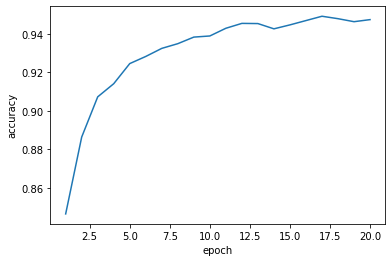

In [ ]:
#Graphical presentation of the result

accuracy=[i['val_acc'] for i in history]
x=[]
for i in range(len(history)):
  x.append(i+1)


plt.plot(x, accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
#Accuracy of the testset

f=[]

for img, label in test_loader:
  outputs = model(img)
  _, preds  = torch.max(outputs, dim=1)
  t=torch.tensor(torch.sum(preds == label).item() / len(preds))
  f.append(t)


Sum=sum(f)
print(Sum/len(f))

tensor(0.9517)


In [ ]:
torch.save(model.state_dict(), 'mnst.logistic.pth')

In [ ]:
#Trying out the saved model

model2=MnistModel(input_size, out_size=num_classes)
model2.load_state_dict(torch.load('mnst.logistic.pth'))
model2.state_dict




f=[]

for img, label in test_ds:
  outputs = model2(img)
  _, preds  = torch.max(outputs, dim=1)
  t=torch.tensor(torch.sum(preds == label).item() / len(preds))
  f.append(t)


Sum=sum(f)
print(Sum/len(f))




tensor(0.9518)


In [ ]:
# with some individual images:

def predict_image(img, model2):
    xb = img.unsqueeze(0)
    yb = model(xb)
    print(yb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = test_ds[46]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model2))

print(img[0])




In [ ]:

from IPython.display import display, Javascript, Image
import cv2
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import PIL
import io
import html
import time



# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # save image
  cv2.imwrite(filename, img)

  return img

In [ ]:
x=take_photo()

<IPython.core.display.Javascript object>

In [ ]:
img_array_test=cv2.imread("/content/photo.jpg")
new_img_array_test=cv2.resize(img_array_test,(64,64))
new_img_array_test2=new_img_array_test/255

In [ ]:
inverse=1 - new_img_array_test2
inverse_test = np.array(inverse)
inverse_test_float=inverse_test.astype('float32')
inverse_test_tensor=torch.from_numpy(inverse_test_float)

print(predict_image(img, model2))



tensor([[-6.8274,  6.4903, -0.3940,  3.3753, -1.7823, -1.7014, -4.1278,  1.2011,
          1.6189, -1.3595]], grad_fn=<AddmmBackward>)
1


In [ ]:

import tensorflow as tf
import keras


plt.imshow(imgResized, cmap='gray')
Gray=cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

Gray1=cv2.resize(Gray, (28, 28))

Gray2=torch.tensor(Gray1)
Gray3 = Gray2.type(torch.float32)
Gray4 = Gray3.unsqueeze(0)
Gray5=tf.keras.utils.normalize(Gray4, axis=1)

print(Gray5.shape)
print(Gray5.dtype)
print(Gray5)

print('Predicted:', predict_image(Gray5, model2))




In [ ]:
uploaded=files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))



In [ ]:

import tensorflow as tf
import keras

y=cv2.imread('3 (11).jpg')
#picture=resize(y, (28,28), mode='constanst', antialiasing=True)
y1=cv2.resize(y, (28, 28))
y2=cv2.cvtColor(y1, cv2.COLOR_BGR2GRAY)
y3=torch.tensor(y2)
y4 = y3.type(torch.float32)
y5 = y4.unsqueeze(0)
y6=tf.keras.utils.normalize(y5, axis=1)
print(y6.shape)
print(y6.dtype)
print(y6)


#print('Predicted:', predict_image(y6, model2))

In [ ]:
print('Predicted:', predict_image(y6, model2))

tensor([[-1.5928,  0.6344,  1.2368,  6.0241, -1.6542,  1.7492, -3.2911, -2.0907,
          2.0241, -1.4299]], grad_fn=<AddmmBackward>)
Predicted: 3
